    Ben Christensen
    Math 345
    11/27/17

Perform image compression using the Spectral Value Decomposition

In [1]:
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt

In [2]:
# Problem 1
def compact_svd(A, tol=1e-6):
    """Compute the truncated SVD of A.

    Parameters:
        A ((m,n) ndarray): The matrix (of rank r) to factor.
        tol (float): The tolerance for excluding singular values.

    Returns:
        ((m,r) ndarray): The orthonormal matrix U in the SVD.
        ((r,) ndarray): The singular values of A as a 1-D array.
        ((r,n) ndarray): The orthonormal matrix V^H in the SVD.
    """
    Hermitian = np.dot(A.conj().T, A)
    evals, evecs = la.eig(Hermitian)
    singulars = np.sqrt(evals)
    sorting = np.argsort(singulars)[::-1]
    singulars = np.sort(singulars)[::-1]
    m, n = evecs.shape

    V = np.zeros((m,n))
    for i in range(n):
        V[i] = evecs[:,sorting[i]]

    r = 0
    for i, singular in enumerate(singulars):
        r += 1
        if singular < tol:
            zero_singular = i
            break

    c_singulars = singulars[:i+1]
    c_V = V[:, :i+1]
    c_U = (A @ c_V) / c_singulars

    return c_U, c_singulars, c_V.conj().T



# Problem 2
def visualize_svd(A):
    """Plot the effect of the SVD of A as a sequence of linear transformations
    on the unit circle and the two standard basis vectors.
    """
    theta = np.linspace(0, 2*np.pi, 200)
    x = np.cos(theta)
    y = np.sin(theta)
    S = np.vstack((x,y))
    E = np.array([[1, 0, 0],
                    [0, 0, 1]])
    U, s, Vh = la.svd(A)
    plt.subplot(221)
    plt.axis("equal")
    plt.plot(S[0], S[1])
    plt.plot(E[0], E[1])

    plt.subplot(222)
    plt.axis("equal")
    tempS = Vh @ S
    tempE = Vh @ E
    plt.plot(tempS[0], tempS[1])
    plt.plot(tempE[0], tempE[1])

    plt.subplot(223)
    plt.axis("equal")
    tempS = np.diag(s) @ Vh @ S
    tempE = np.diag(s) @ Vh @ E
    plt.plot(tempS[0], tempS[1])
    plt.plot(tempE[0], tempE[1])

    plt.subplot(224)
    plt.axis("equal")
    tempS = U @ np.diag(s) @ Vh @ S
    tempE = U @ np.diag(s) @ Vh @ E
    plt.plot(tempS[0], tempS[1])
    plt.plot(tempE[0], tempE[1])

    plt.show()



# Problem 3
def svd_approx(A, s):
    """Return the best rank s approximation to A with respect to the 2-norm
    and the Frobenius norm, along with the number of bytes needed to store
    the approximation via the truncated SVD.

    Parameters:
        A ((m,n), ndarray)
        s (int): The rank of the desired approximation.

    Returns:
        ((m,n), ndarray) The best rank s approximation of A.
        (int) The number of entries needed to store the truncated SVD.
    """
    U, e, Vh = la.svd(A, full_matrices=False)
    if s > np.linalg.matrix_rank(A):
        raise ValueError("'s' is larger than the rank of A")
    U = np.delete(U, np.s_[s:], 1)
    e = np.delete(e, np.s_[s:])
    Vh = np.delete(Vh, np.s_[s:], 0)

    As = U @ np.diag(e) @ Vh
    return As, U.size + e.size + Vh.size


# Problem 4
def lowest_rank_approx(A, err):
    """Return the lowest rank approximation of A with error less than 'err'
    with respect to the matrix 2-norm, along with the number of bytes needed
    to store the approximation via the truncated SVD.

    Parameters:
        A ((m, n) ndarray)
        err (float): Desired maximum error.

    Returns:
        A_s ((m,n) ndarray) The lowest rank approximation of A satisfying
            ||A - A_s||_2 < err.
        (int) The number of entries needed to store the truncated SVD.
    """
    U, e, Vh = la.svd(A, full_matrices=False)
    for i, val in enumerate(e):
        if val < err:
            break
    if err <= e[-1]:
        raise ValueError("A cannot be approximated within tolerance by a matrix of lesser rank")
    U = np.delete(U, np.s_[i:], 1)
    e = np.delete(e, np.s_[i:])
    Vh = np.delete(Vh, np.s_[i:], 0)

    As = U @ np.diag(e) @ Vh
    return As, U.size + e.size + Vh.size



# Problem 5
def compress_image(filename, s):
    """Plot the original image found at 'filename' and the rank s approximation
    of the image found at 'filename.' State in the figure title the difference
    in the number of entries used to store the original image and the
    approximation.

    Parameters:
        filename (str): Image file path.
        s (int): Rank of new image.
    """
    image = plt.imread(filename) / 255
    plt.subplot(121)
    if np.ndim(image) < 3:
        plt.imshow(image, cmap="gray")
        plt.axis("off")
        As, new_size = svd_approx(image, s)
        As = np.clip(As, 0, 1)
        plt.subplot(122)
        plt.imshow(As, cmap="gray")

    else:
        plt.imshow(image)
        plt.axis("off")
        Rs, r = svd_approx(image[:,:,0], s)
        Gs, g = svd_approx(image[:,:,1], s)
        Bs, b = svd_approx(image[:,:,2], s)
        As = np.dstack((Rs, Gs, Bs))
        As = np.clip(As, 0, 1)
        new_size = r + g + b
        plt.subplot(122)
        plt.imshow(As)

    diff = image.size - new_size

    plt.axis("off")
    plt.suptitle(str(diff))
    plt.show()


[[1 1 1 0]
 [0 0 0 0]
 [2 2 2 0]] 12
(array([[ 1.,  1.,  1., -0.],
       [-0., -0., -0.,  0.],
       [ 2.,  2.,  2., -0.]]), 8)


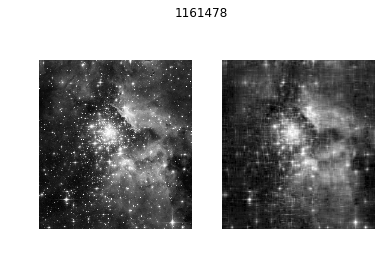

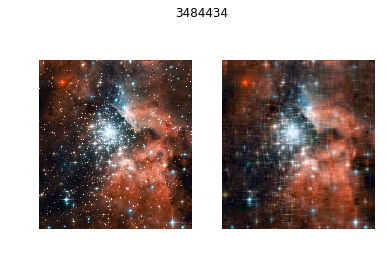

In [3]:
A = np.array([[1, 1, 1, 0], [0, 0, 0, 0], [2, 2, 2, 0]])
err = .1
print(A, A.size)
print(lowest_rank_approx(A, err))

compress_image("/Users/benchristensen/Desktop/ACME Python Labs/Volume1-Student-Materials/SVD_ImageCompression/hubble_gray.jpg", 20)
compress_image("/Users/benchristensen/Desktop/ACME Python Labs/Volume1-Student-Materials/SVD_ImageCompression/hubble.jpg", 20)